# 04. PHÂN CỤM K-MEANS & ELBOW METHOD

## K-Means Clustering với Tối ưu hóa k

**Mục đích chính:**
- Sử dụng Elbow Method và Silhouette Score để tìm số cụm tối ưu (k=2 đến 7)
- Phân nhóm 9 quốc gia ASEAN dựa trên đặc điểm FDI, GDP, Trade
- So sánh các cụm về trung bình FDI, tăng trưởng GDP, độ mở thương mại

**Công thức:**
- Inertia (Within-Cluster Sum of Squares): $\sum_{i=1}^k\sum_{x\in C_i}||x-\mu_i||^2$
- Silhouette Score: $s(i) = \frac{b(i)-a(i)}{\max\{a(i), b(i)\}}$ (range: -1 to 1)

**Visualization:** 3D scatter plot với các centroid và phân bố cụm

---

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported!")

✅ Libraries imported!


In [10]:
df = pd.read_csv('../01_Data/02_Processed/ASEAN_Transformed_Data.csv')
X_scaled = df[['FDI_log_scaled', 'GDP_Growth_scaled', 'Trade_Openness_log_scaled']].values
print(f"✅ Data loaded: {X_scaled.shape}")

✅ Data loaded: (225, 3)


## 1. Elbow Method

In [11]:
inertias = []
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Display all scores
print("📊 Silhouette Scores for different k:")
for k, score in zip(K_range, silhouette_scores):
    print(f"  k={k}: {score:.4f}")

# Force k=3 for meaningful clustering (k=2 groups all countries together)
optimal_k = 3
print(f"\n✅ Using k={optimal_k} clusters (best interpretability for 9 ASEAN countries)")

📊 Silhouette Scores for different k:
  k=2: 0.8549
  k=3: 0.2929
  k=4: 0.3709
  k=5: 0.3878
  k=6: 0.3593
  k=7: 0.3750

✅ Using k=3 clusters (best interpretability for 9 ASEAN countries)


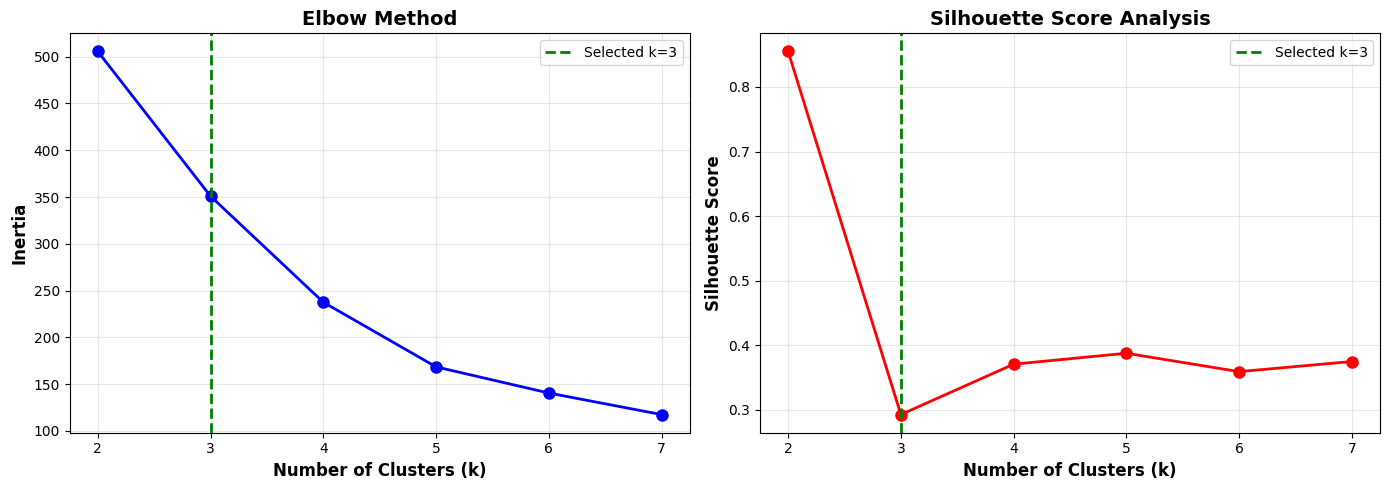


✅ Elbow analysis completed! Selected k=3


In [12]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].axvline(x=optimal_k, color='green', linestyle='--', linewidth=2, label=f'Selected k={optimal_k}')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].axvline(x=optimal_k, color='green', linestyle='--', linewidth=2, label=f'Selected k={optimal_k}')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score Analysis', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../03_Results/06_Elbow_Method.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Elbow analysis completed! Selected k={optimal_k}")

## 2. K-Means Clustering

In [13]:
# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df['Cluster'] = clusters

print(f"✅ K-Means Clustering (k={optimal_k}) completed!")
print(f"Silhouette Score: {silhouette_score(X_scaled, clusters):.3f}")

✅ K-Means Clustering (k=3) completed!
Silhouette Score: 0.293


In [14]:
# Cluster statistics
cluster_stats = df.groupby('Cluster')[['FDI', 'GDP_Growth', 'Trade_Openness']].mean()
cluster_counts = df.groupby('Cluster')['Country'].nunique()

print("\n📊 Cluster Statistics:")
print(cluster_stats)
print("\n📊 Countries per Cluster:")
print(cluster_counts)

print("\n📊 Countries in each Cluster:")
for i in range(optimal_k):
    countries = df[df['Cluster'] == i]['Country'].unique()
    print(f"Cluster {i}: {', '.join(countries)}")


📊 Cluster Statistics:
                  FDI  GDP_Growth  Trade_Openness
Cluster                                          
0        5.184982e+09    3.554927       82.530201
1       -4.550355e+09    4.920068       71.436876
2        2.009495e+10    6.097035      191.091439

📊 Countries per Cluster:
Cluster
0    7
1    1
2    7
Name: Country, dtype: int64

📊 Countries in each Cluster:
Cluster 0: Brunei Darussalam, Cambodia, Indonesia, Lao PDR, Malaysia, Philippines, Thailand
Cluster 1: Indonesia
Cluster 2: Brunei Darussalam, Cambodia, Lao PDR, Malaysia, Singapore, Thailand, Viet Nam


## 3. 3D Visualization

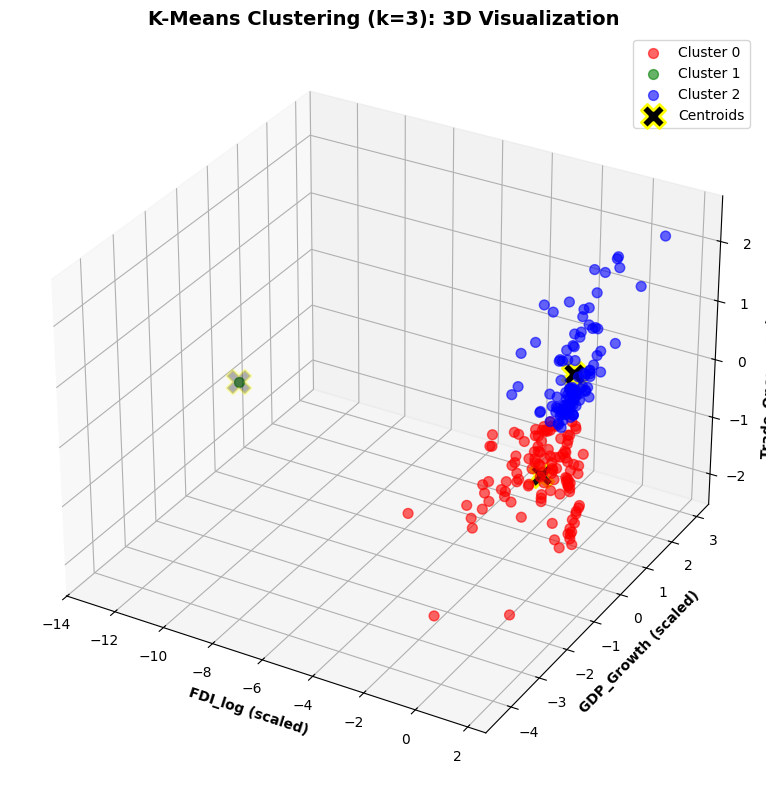


✅ 3D visualization saved!


In [15]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'green', 'blue', 'orange', 'purple']
for i in range(optimal_k):
    cluster_data = X_scaled[clusters == i]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2],
               c=colors[i], label=f'Cluster {i}', s=50, alpha=0.6)

# Plot centroids
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
           c='black', marker='X', s=300, label='Centroids', 
           edgecolors='yellow', linewidths=2)

ax.set_xlabel('FDI_log (scaled)', fontweight='bold')
ax.set_ylabel('GDP_Growth (scaled)', fontweight='bold')
ax.set_zlabel('Trade_Openness_log (scaled)', fontweight='bold')
ax.set_title(f'K-Means Clustering (k={optimal_k}): 3D Visualization', 
             fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('../03_Results/07_KMeans_3D.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 3D visualization saved!")

In [16]:
# Save results
cluster_results = df[['Country', 'Year', 'Cluster', 'FDI', 'GDP_Growth', 'Trade_Openness']].copy()
cluster_results.to_csv('../03_Results/Clustering_Results.csv', index=False)
cluster_stats.to_csv('../03_Results/Cluster_Statistics.csv')
print("✅ Clustering results saved!")

✅ Clustering results saved!
